# Proyecto 1 BI
#### Grupo 8

***Estudiantes:*** 

A continuación se presenta el algoritmo que implementó cada persona

- Alejandro Hoyos - 202215277 - KNN
- Andrés Bolívar - 202214834 - Arboles de decision
- Luis Pinilla - 202221306 - Naive Bayes

## Importación de librerías

In [303]:
#Cosas de toda la vida 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#Limpia Texto
import unicodedata as unicodedata
import re
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords

#Lematizar
from nltk.stem.snowball import SnowballStemmer

#BOW / vectorizar
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

#balanceo de clases
from imblearn.under_sampling import RandomUnderSampler

# Naive Bayes

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

#Árboles de decisión
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
)

# KNN
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luchopinilla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploración de los datos

### Tipos de dato
- Son tres columnas ("",texto, labels) en las que una es simplemente el comentario, otra es ODS asociado
- Por cada ODS existen 
    ODS 1 : 505 
    ODS 3 : 894
    ODS 4 : 1025


#### Notas para la limpieza
- Toca balancear las entradas por tipo de ODS
- Toca procesar toda la columna de texto para poder descifrar a que ODS se puede clasificar
- Sorprendentemente no hay Nulos en ninguna de las columnas
- Tampoco hay filas duplicadas.
- Tampoco hay valores anómalos... todas las etiquetas corresponden a una de las ODS

In [304]:
#Carga de los datos 
TrainData = pd.read_excel("../data/Datos_proyecto.xlsx")
TrainData.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


In [305]:
# Entradas de la BD 
TrainData.shape


(2424, 2)

In [306]:
# Valores nulos  
print("Valores en nulo \n",TrainData.isnull().sum())
TrainData.info()

Valores en nulo 
 textos    0
labels    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


In [307]:
# Filas duplicadas
nDuplicados= TrainData.duplicated().sum()
print(nDuplicados)


0


In [308]:
#Entradas diferentes en la columna labels, cada uno corresponde a un ODS.
ods_entradas = TrainData["labels"].value_counts().sort_index()
print("Cuenta del número de entradas por cada ODS")
print(ods_entradas.to_frame("cuenta"))


Cuenta del número de entradas por cada ODS
        cuenta
labels        
1          505
3          894
4         1025


## Limpieza Básica 
1. **Convertir a string (`astype(str)`):**  
   Nos aseguramos de que toda la columna de textos sea del tipo `str`, evitando errores si hay valores numéricos o nulos.

2. **Eliminar mayúsculas (`texto.lower()`):**  
   Pasamos todo a minúsculas para evitar que palabras como *Educación* y *educación* se traten como diferentes.

3. **Eliminar acentos (`unicodedata.normalize`):**  
   Quitamos tildes y caracteres raros (ej: `á -> a`, `ü -> u`), lo que facilita el procesamiento y uniformiza las palabras.

4. **Eliminar puntuación y caracteres especiales (`re.sub`):**  
   Quitamos símbolos, números y signos de puntuación que no aportan al modelo, dejando solo letras y espacios.

In [309]:
# Volver la columna "texto" en string
TrainData["textos"] = TrainData["textos"].astype(str)
TrainData.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


In [310]:
#Eliminar las mayúsculas (pasar a minúsculas)
def eliminar_mayusculas(texto):
    return texto.lower()

TrainData.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


In [311]:
# Eliminar Acentos No solo tildes sino otros caracteres raros
def eliminar_acentos(texto):
    "esta función es más robusta que usar regex porque maneja caracteres raros raros (ñ, ü, etc)"
    textico = unicodedata.normalize("NFD",texto)
    limpio = "".join(c for c in textico if unicodedata.category(c) != "Mn")
    return limpio

TrainData["textos"] = TrainData["textos"].apply(eliminar_acentos)
TrainData.head()

,textos,labels
0,"""Aprendizaje"" y ""educacion"" se consideran sino...",4
1,Para los ninos mas pequenos (bebes y ninos peq...,4
2,"Ademas, la formacion de especialistas en medic...",3
3,En los paises de la OCDE se tiende a pasar de ...,4
4,Este grupo se centro en las personas que padec...,3


In [312]:
# quitar signos de puntuación y caracteres especiales (excepto cosas portentuales )

def limpiar_puntuacion(texto):
    texto = re.sub(r"[^A-Za-z0-9/\-\s%]", " ", texto)
    texto = re.sub(r"\s+", " ", texto).strip()
    return texto

TrainData["textos"] = TrainData["textos"].apply(limpiar_puntuacion)
TrainData.head()

,textos,labels
0,Aprendizaje y educacion se consideran sinonimo...,4
1,Para los ninos mas pequenos bebes y ninos pequ...,4
2,Ademas la formacion de especialistas en medici...,3
3,En los paises de la OCDE se tiende a pasar de ...,4
4,Este grupo se centro en las personas que padec...,3


## Tokenización 
En esta fase dividimos cada texto en una lista de palabras individuales (tokens).  
Decidimos usar el método `split()` porque:

- Es sencillo y rápido, epara por espacios y nos devuelve cada palabra.  
- Se adapta bien a nuestro flujo, ya que después eliminamos stopwords y aplicamos otras transformaciones.  
- No dependemos de librerías externas pesadas (como NLTK o spaCy) para esta parte, lo que mejora el rendimiento (intentamos usarlas pero demoraban minutos en correr).

Este paso es bien importante porque transforma un texto largo en una estructura manejable (listas de palabras), lo que facilita eliminar stopwords, lematizar y otras transofrmaciones que se hacen después. 

In [313]:
# Usamos la función de la librería nltk para tokenizar cada texto
def tokenizar(texto):
    return texto.split()


TrainData["textos"] = TrainData["textos"].apply(tokenizar)
# Revisar tipos únicos en la columna
print(TrainData["textos"].map(type).value_counts())

TrainData.head()
     

textos
<class 'list'>    2424
Name: count, dtype: int64


,textos,labels
0,"[Aprendizaje, y, educacion, se, consideran, si...",4
1,"[Para, los, ninos, mas, pequenos, bebes, y, ni...",4
2,"[Ademas, la, formacion, de, especialistas, en,...",3
3,"[En, los, paises, de, la, OCDE, se, tiende, a,...",4
4,"[Este, grupo, se, centro, en, las, personas, q...",3


## Eliminar Stop Words 

En esta fase eliminamos las *stop words*  como "para", "los", "de", "y", etc.  

Decidimos hacerlo porque:
- Son palabras muy frecuentes que **no aportan significado relevante** al modelo.  
- Reducen el ruido en el texto, mejorando la representación en el Bag of Words.  
- Ayuda a que el modelo se enfoque en términos más discriminativos, como *educación*, *salud*, *formación*. 
- Ademas computacionalemnte nos va a ahorrar mucho peso en los siguientes pasos.  

Usamos la lista de `stopwords` en español de **NLTK**, y filtramos los tokens para quedarnos únicamente con las palabras que aportan valor.

In [314]:
# Eliminar las stop words de la columna textos

def eliminar_stopwords(texto):
    stop_words = set(stopwords.words('spanish'))
    nuevo_texto = [palabra for palabra in texto if palabra not in stop_words]
    return nuevo_texto

TrainData["textos"]= TrainData["textos"].apply(eliminar_stopwords)

TrainData.head()


,textos,labels
0,"[Aprendizaje, educacion, consideran, sinonimos...",4
1,"[Para, ninos, mas, pequenos, bebes, ninos, peq...",4
2,"[Ademas, formacion, especialistas, medicina, g...",3
3,"[En, paises, OCDE, tiende, pasar, cursos, obli...",4
4,"[Este, grupo, centro, personas, padecen, trast...",3


## Lematizar 
En esta fase reducimos las palabras a su forma base o raíz.  
Por ejemplo, *educación*, *educar*, *eduquemos* → todas pasan a la raíz *educ*.

- Evita que el modelo cuente como diferentes palabras aquellas que tienen la misma raíz.  
- Mejora la representación en el Bag of Words, reduciendo la dimensionalidad.  
- Permite que las frecuencias sean más representativas del concepto general.  

**NOTA:**
Inicialmente probamos con **spaCy**, que tiene un lematizador mucho más preciso (capaz de identificar la forma gramatical real de la palabra).  
Sin embargo, tardó **más de 10 minutos en procesar el dataset completo**, lo que lo hacía inviable en este caso.  
Por esa razón decidimos usar el **SnowballStemmer de NLTK**, que aunque es un *stemmer* (recorta palabras a su raíz sin tanto contexto gramatical), es mucho más rápido y suficiente para nuestros fines de clasificación.


In [315]:
def lematizar_texto(tokens):
    stemeador = SnowballStemmer("spanish")
    lematizados = [stemeador.stem(token) for token in tokens]
    return lematizados


TrainData["textos"] = TrainData["textos"].apply(lematizar_texto)
print(TrainData["textos"].head())

0    [aprendizaj, educ, consider, sinon, escolariz,...
1    [par, nin, mas, pequen, beb, nin, pequen, capa...
2    [adem, formacion, especial, medicin, general, ...
3    [en, pais, ocde, tiend, pas, curs, obligatori,...
4    [este, grup, centr, person, padec, trastorn, m...
Name: textos, dtype: object


## BOW

Convertimos cada documento en un vector de conteos: cuántas veces aparece cada palabra (del vocabulario) en ese texto.  
Esto nos da una **matriz dispersa** (sparse) que los modelos pueden usar.
 
- Es simple, rápido y efectivo para textos cortos/medios.  
- Con el preprocesamiento (minúsculas, acentos, stopwords, stemming) el vocabulario queda más limpio y el modelo aprende mejor.

**Parámetros clave de `CountVectorizer` que usamos:**
- `token_pattern=r"(?u)\b[a-z]{2,}\b"`  
  Solo acepta **tokens alfabéticos** de ≥2 letras (evitamos 1-letras y ruido).  
- `min_df=3`  
  Ignora palabras que aparecen en **menos de 3** documentos (ruido raro).  
- `max_df=0.90`  
  Ignora palabras que aparecen en **>90%** de los documentos (demasiado comunes).  
- `ngram_range=(1, 2)`  
  Incluye **unigramas** y **bigramas** (ej. “educacion”, “educacion inclusiva”). Los bigramas capturan un poco de contexto.  
- `max_features=None`  
  Sin límite explícito del vocabulario; dejamos que `min_df/max_df` lo controlen.


  De esta manera intentamos limipiar lal mayor cantidd de ruido posible. 

  **NOTA IMPORTANTE**

  EL VECTORIZADOR DE ESTA FASE ES EL QUE VAMOS A USAR EN EL TEST.. PUES ESTE VECTORIZADOR ESTÁ ENTRENADO CON EL DATASET DE ENTRENAMIENTO    .

In [316]:
# Vectorizar y generar el BoW

def join_tokens(tokens):
    return " ".join(tokens)

def entrenar_vectorizador(textos):
    """
    textos: lista/Serie de strings (textos limpios)
    """
    vectorizador = CountVectorizer(token_pattern=r"(?u)\b[a-z]{2,}\b", min_df=3, max_df=0.90, ngram_range=(1,2), max_features=None )
    vectorizador.fit(textos)
    return vectorizador

def transformar_bow(vectorizador, textos):
    bow = vectorizador.transform(textos)
    return bow


TrainData["textos"] = TrainData["textos"].apply(join_tokens)
vectorizador_bow = entrenar_vectorizador(TrainData["textos"])

#ESTE ES EL QUE USAMOS  EN FORMATO DE MATRIZ DISPERSA DE SCIKIT-LEARN
bow = transformar_bow(vectorizador_bow, TrainData["textos"])

X = bow
y = TrainData["labels"]

# ESTOS DATOS SON IMPORTANTES PORQUE SON LOS QUE SE VAN A USAR PARA ENTRENADO Y PROBAR LOS MODELOS
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

#Lo paso a un DataFrame solo para visualización: 

print("Número de palabras en el vocabulario:", len(vectorizador_bow.vocabulary_))
print("Shape del BoW:", bow.shape)
#Pasarlo de una matriz de scipy a una array numpy y finalmente a un dataframe de pandas
bowDF = pd.DataFrame(bow.toarray(), columns=vectorizador_bow.get_feature_names_out())
bowDF.head()




Número de palabras en el vocabulario: 10189
Shape del BoW: (2424, 10189)


,abaj,abaj haci,abandon,abandon escol,abandon escuel,abandon estudi,abandon profesion,abarc,abiert,abog,...,xix,xx,xxi,ya,york,zeland,zon,zon remot,zon rural,zon urban
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## **Modelado** 



### Naive Bayes 


El modelo **Naive Bayes** es muy adecuado para clasificación de texto porque:  
- Es rápido y eficiente incluso con vocabularios grandes.  
- Se adapta naturalmente al **Bag of Words**, ya que trabaja con frecuencias y las interpreta como probabilidades.  
- El suavizado de Laplace (`alpha`) evita que palabras poco frecuentes distorsionen el modelo.  

**Para la clasificación de ODS**
- Después de la **limpieza, tokenización, eliminación de stopwords y lematización**, el texto queda reducido a las palabras más representativas.  
- Cada ODS tiene un **vocabulario característico**:  
  - ODS 1: pobreza, desigualdad, recursos.  
  - ODS 3: salud, enfermedades, mortalidad.  
  - ODS 4: educación, formación, escolaridad.  
  Bayes funciona bien cuando hay estas palabras clave que diferencian con claridad las clases.  
- Con el **balanceo de clases** aseguramos que el modelo no se sesgue hacia la categoría mayoritaria.  

**Metricas**

Se eligió la **F1 macro** como métrica principal porque:  
- Es la que se usará para evaluar los modelos (enunciado)
- Combina **precisión**  y **recall** (qué tanto cubre de los casos reales).  
- Así se puede balancear y garantizamos un rendimiento equilibrado en **todas las categorías** y no solo en la más frecuente.  

**Síntesis**

Con `GridSearchCV` optimizamos el `alpha` y obtuvimos un **F1 ≈ 0.97**, lo que confirma que el modelo es rápido, interpretable y muy efectivo para clasificar documentos según los ODS.

In [317]:
# Usamos multinomialNB con diferentes alpha

# division de datos en bow
#X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.25, random_state=42, stratify=y). 


def naive_bayes(x,y):
    "x son los datos bow y las etiquetas y a es el alpha"

    alpha_grid = {"alpha": [0.05, 0.1,0.3, 0.5, 1.0, 2.0]}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # este bitcito hace cross validation

    modelo = GridSearchCV(estimator = MultinomialNB(), param_grid = alpha_grid, scoring = "f1_macro",refit = "f1_macro", cv = cv, n_jobs = -1)
    modelo.fit(x, y)
    return modelo


modelo_nb = naive_bayes(X_train, y_train)

# Resultados del modelo entrenado
print("Mejores hiperparámetros:", modelo_nb.best_params_)
print("Mejor puntuación F1:", modelo_nb.best_score_)



Mejores hiperparámetros: {'alpha': 0.1}
Mejor puntuación F1: 0.976712640405197


### Arboles de desicion 

Para el proyecto, el uso de árboles es adecuado porque:
- Facilita la interpretabilidad de los resultados, ya que establece reglas claras acerca de las palabras más relevantes que permiten clasificar cada opinión en su respectivo ODS.
- Los árboles se adaptan bien a estructuras son representaciones dispersas con muchas columnas binarias o de conteo (caso del BOW) porque saben dividir según la presencia o ausencia de palabras.

La construcción del modelo usando el algoritmo de Árboles de decisión se basa en el uso de GridSearch para probar varias configuraciones de hiperparámetros y determinar, entre dichas configuraciones, cuál es el mejor modelo para hallado con este algoritmo.
Primero que todo, se fija la semilla en los modelos que se crean dentro de la grilla para que los resultados no se vean afectados por los cambios en la aleatoriedad del modelo para tomar ciertas decisiones.
Además, en los parámetros de la grilla se establecen 5 hiperparámetros para los modelos de árboles de decisión con el fin de evaluar el rendimiento en las distintas configuraciones:
- criterion: Define el criterio de impureza que usa el modelo para elegir los cortes que realiza en cada nodo del árbol
- max_depth: Controla la profundidad máxima que puede tener el árbol resultante. Las opciones se varían desde poca profundidad, donde se puede incurrir en problemas de subajuste, hasta una profundidad sin restricciones, donde se puede incurrir en problemas de sobreajuste.
- min_samples_split: Controla el mínimo número de muestras que se deben tener en un nodo para considerar dividirlo.
- min_samples_leaf: Control cuánto es el menor número de muestras posible que pueden quedar en una hoja, un nodo resultante de una división de un nodo padre.
- class_weight: Determina si se establece una ponderación para penalizar los errores de acuerdo con la frecuencia de las clases. El parámetro puede ser útil para el caso del proyecto si se considera el desbalanceo que hay en los datos de entrenamiento.

Con esto en mente, la búsqueda en la grilla se realiza teniendo en cuenta que se quiere maximizar el f1-score (macro). La métrica escogida permite comprimir en una sola métrica la precisión (porcentaje de datos identificados como de cierta clase X que realmente son de la clase X) y el recall (porcentaje de datos de la clase X detectados como de la clase X). Además, se le da el mismo peso en cuanto a importancia a cada una de las clases al hacer un promedio simple de los f1-score de cada clase.

Finalmente, la búsqueda en la grilla permite identificar que la mejor configuración para el modelo de árboles de decisión es:
- criterion: Gini.
- max_depth: 10.
- min_samples_split: 20.
- min_samples_leaf: 5.
- class_weight: None.

Con estos hiperparámetros se consigue un f1-score macro en train de 0,9295. Asimismo, resulta relevante resaltar que la mejor configuración no controla el desbalanceo de clases, permite una profundidad del árbol relativamente alta, previene realizar divisiones en nodos con pocas muestras y suaviza el árbol al garantizar que en cada nodo queden al menos 5 muestras.


In [318]:
def arbol(x,y,param_grid):
    grid = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=42),
        param_grid=param_grid,
        scoring='f1_macro',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    grid.fit(x,y)
    return grid

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6, 8, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 3, 5, 10],
    'class_weight': [None, 'balanced']
}
modelo_arboles = arbol(X_train, y_train,param_grid)
print("Mejores hiperparámetros:", modelo_arboles.best_params_)
print("Mejor score de CV (f1-score):", round(modelo_arboles.best_score_, 4))

Mejores hiperparámetros: {'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}
Mejor score de CV (f1-score): 0.9295


### KNN

El modelo **KNN (k-Nearest Neighbors)** es muy adecuado para clasificación de texto cuando representamos los documentos en un espacio TF-IDF con normalización L2:  
- Entrenamiento inmediato.  
- Decide por vecindad, documentos cercanos comparten vocabulario/tema o en este caso el ODS.  
- Encaja bien con TF-IDF+L2 pues en estos casos la similitud del lenguaje se vuelve geometrìa distancia entre vectores y demás.  

**Para la clasificación de ODS**
- Después de la **limpieza, tokenización, eliminación de stopwords y lematización**, el texto queda reducido a las palabras más representativas y cada texto se vectoriza con TF-IDF y normaliza con L2.  
- Cada ODS tiene un **vocabulario característico**:  
  - ODS 1: pobreza, desigualdad, recursos.  
  - ODS 3: salud, enfermedades, mortalidad.  
  - ODS 4: educación, formación, escolaridad.   
- **KNN** captura esos patrones porque compara qué terminos y con qué pesos aparecen en cada documento y así busca los más parecidos  

**Qué hace TF-IDF+L2**
- Da más pesos a términos que son más informativos o menos frecuentes y menos pesos a los que son muy frecuentes.
- "l2" normaliza cada documento a norma 1.

**Por qué se usa el pipeline como estimador en GridSearchCV**
- Evita el leakage
- Es la forma correcta de garantiza validación y despliegue sencillo

**Hiperparámetros**
- **"knn__n_neighboors"**: Controla sesgo y varianza entre el k sea muy pequeño es muy flexible mientras que si el k es grande suele ser más estable y suaviza el ruido. Se prueba con un rango amplio e impar.
- **"knn__weigths"**: uniform indica que todos los vecinos pesan igual mientras que distance le brinda más peso al vecino más cercano. 
- **"knn__metric" y "knn__p"**: Minkowski con p1 que indica que es Manhatan solo funciona como si te moviera en distancias ortogonales mientras que la Euclidiana como si te moviera con una linea recta hacia el otro vecino.

**Métricas**
Se eligió la **F1 macro** como métrica principal porque:  
- Combina **precisión**  y **recall** (qué tanto cubre de los casos reales).  
- Métrica solicitada para evaluar el proyecto.  

**Síntesis**
Modelé con KNN porque con documentos en TF-IDF+L2, la proximidad refleja similitud semántica de forma clara. Para evitar fugas y poder ajustar también el preprocesamiento, encapsulé TF-IDF y KNN en un Pipeline y lo pasé a GridSearchCV con f1_macro. La búsqueda seleccionó k=21, weights='distance' y p=2, logrando un F1-macro de CV ≈ 0.97.

In [23]:
def knn(x,y,param_grid, pipe):

  grid_knn = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True,
    verbose=0
  )

  grid_knn.fit(x, y)

  return grid_knn

pipe_knn = Pipeline([
    ("tfidf", TfidfTransformer(use_idf=True, sublinear_tf=True, norm="l2")),
    ("knn", KNeighborsClassifier())
])

param_grid_knn = {
    "knn__n_neighbors": [1, 3, 5, 7, 11, 15, 21, 31],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski"],
    "knn__p": [1, 2],
}

modelo_knn = knn(X_train,y_train,param_grid_knn,pipe_knn)
print("Mejores hiperparámetros:", modelo_knn.best_params_)
print("Mejor score de CV (f1-score):", round(modelo_knn.best_score_, 4))

Mejores hiperparámetros: {'knn__metric': 'minkowski', 'knn__n_neighbors': 21, 'knn__p': 2, 'knn__weights': 'distance'}
Mejor score de CV (f1-score): 0.9771


### Función para evaluar los modelos con datos de test

La siguiente función implementada se encarga de calcular las métricas de rendimiento de cada uno de los modelos entrenados, pero ahora usando los datos de test, con el objetivo de comparar en condiciones insesgadas los modelos.

In [320]:
def evaluar_modelo(clf, X_test, y_test, titulo="Modelo", feature_names=None):
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    print(f"\n=== {titulo} ===")
    print("Accuracy (test):", round(acc, 4))
    print("F1-macro (test):", round(f1_macro, 4))

    # Reporte de clasificación dinámico
    labels = np.unique(y_test)
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=[str(l) for l in labels]))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, colorbar=False, cmap="Blues")
    plt.title(f"Matriz de confusión — {titulo}")
    plt.show()

    # Importancia de características (si el modelo lo permite)
    importances = getattr(clf, "feature_importances_", None)
    if importances is not None:
        try:
            importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
            plt.figure(figsize=(8, 5))
            importances.head(12).plot(kind='bar')
            plt.title(f"Top 12 Importancias — {titulo}")
            plt.xlabel("Características")
            plt.ylabel("Importancia")
            plt.tight_layout()
            plt.show()
        except Exception:
            pass
    
feature_names = vectorizador_bow.get_feature_names_out()

### Evaluación modelo Naive Bayes


=== Modelo con Naive Bayes ===
Accuracy (test): 0.962
F1-macro (test): 0.9578

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.94      0.94      0.94       126
           3       0.96      0.97      0.96       224
           4       0.98      0.97      0.97       256

    accuracy                           0.96       606
   macro avg       0.96      0.96      0.96       606
weighted avg       0.96      0.96      0.96       606



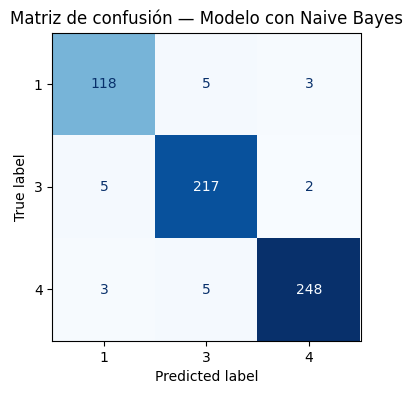

In [321]:
evaluar_modelo(modelo_nb.best_estimator_,X_test,y_test,"Modelo con Naive Bayes",feature_names)


El modelo con NaiveBayes:
- Alcanza un f1-score macro bastante alto de 0,9578, muy cercano a 1. Por tal motivo, el modelo tiene un excelente rendimiento. Logra en general ser muy preciso con sus predicciones y, además, es muy exacto para detectar las opiniones correspondientes a los 3 ODS.
- Tiene un f1-score alto para cada una de las categorías, lo cual se traduce en un f1-score macro alto. En este orden de ideas, el modelo tiene un excelente rendimiento para clasificar correctamente las opiniones en su respectivo ODS, sin importar el ODS, es decir, no se está viendo afectado por el desbalanceo de clases. En otras palabras, sin importar a cuál ODS pertenece una opinión, el modelo en general tiene un buen rendimiento para clasificar la opinión en su correcto ODS.


### Evaluación modelo Árboles de decisión


=== Modelo con Árboles de decisión ===
Accuracy (test): 0.8878
F1-macro (test): 0.8788

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.88      0.80      0.84       126
           3       0.84      0.91      0.87       224
           4       0.94      0.91      0.93       256

    accuracy                           0.89       606
   macro avg       0.89      0.87      0.88       606
weighted avg       0.89      0.89      0.89       606



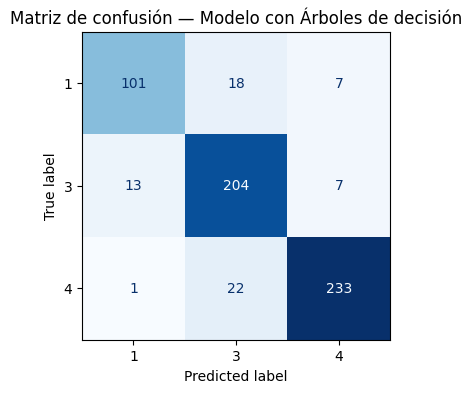

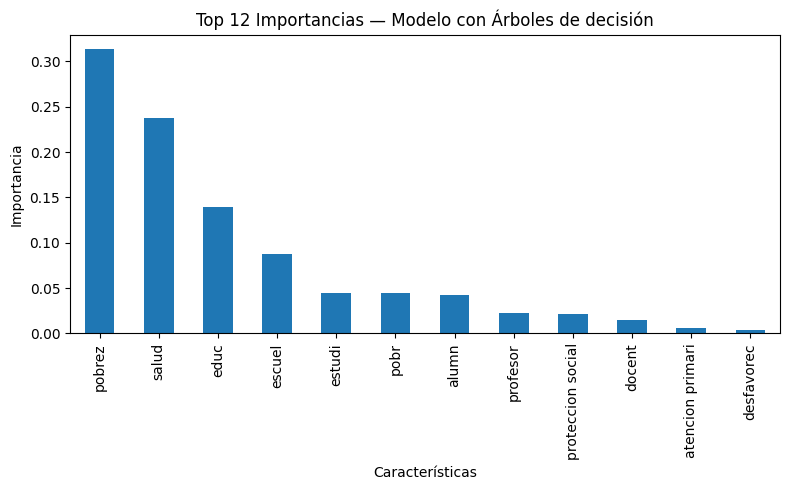

In [322]:
evaluar_modelo(modelo_arboles.best_estimator_,X_test,y_test,"Modelo con Árboles de decisión",feature_names)

El modelo con Árboles de decisión:
- De acuerdo con su f1-score macro de 0,8788, el modelo también está siendo preciso y exacto para realizar sus predicciones, pero no más que el modelo con Naive Bayes.
- Individualmente, el modelo tiene un excelente rendimiento en cuanto a precisión y exactitud en sus predicciones de opiniones que pertenecen al ODS 4 (ODS con más observaciones en el dataset). Sin embargo, su rendimiento no es tan alto para los ODS 1 y 3, por lo que, el rendimiento del modelo se está viendo afectado por el desbalanceo de clases. Este cambio en el rendimiento del modelo para cada clase se ve traducido en un f1-score macro menor al del modelo de Naive Bayes.
- Un valor agregado que brinda este modelo es que permite identificar, en este caso, las palabras que están tomando mayor importancia para clasificar cada una de las opiniones. En este orden de ideas, la gráfica que muestra el top 12 de las palabras más relevantes, muestra claramente que las palabras con mayor importancia son las que representan el enfoque principal de cada ODS: pobreza (ODS 1 es “Fin de la pobreza”), salud (ODS 3 es “Salud y bienestar”) y educación (ODS 4 es “Educación de calidad”).
- Las demás palabras con mayor importancia son palabras fuertemente relacionadas a dicho enfoque de los ODS: desfavorecimiento, protección social, atención primaria, escuela, estudio, alumno, profesor, docente.


### Evaluación modelo KNN


=== Modelo con KNN ===
Accuracy (test): 0.9505
F1-macro (test): 0.9457

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.95      0.90      0.92       126
           3       0.94      0.96      0.95       224
           4       0.96      0.96      0.96       256

    accuracy                           0.95       606
   macro avg       0.95      0.94      0.95       606
weighted avg       0.95      0.95      0.95       606



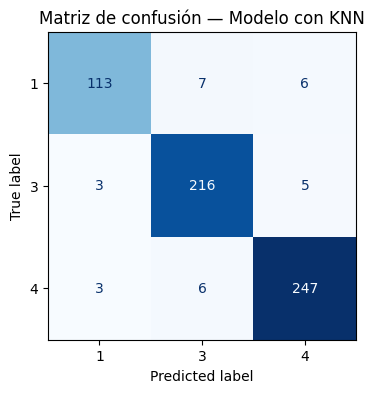

In [323]:
evaluar_modelo(modelo_knn.best_estimator_,X_test,y_test,"Modelo con KNN",feature_names)

El modelo con KNN:
- Tiene un f1-score macro de 0,9457. Tiene un rendimiento similar (levemente menor) al del modelo con Naive Bayes. Igualmente, el modelo es muy preciso con las predicciones que realiza, es decir, un alto porcentaje de las predicciones que realiza son correctas. Además, el modelo logra detectar con una alte exactitud la clasificación correcta de las opiniones.
- Al igual que el modelo con Naive Bayes, tiene un rendimiento alto y equilibrado para los ODS 1, 3 y 4. En otras palabras, el rendimiento del modelo no disminuye considerablemente para clasificar opiniones en cada una de las clases (en cada uno de los ODS).


## Resultados

- Tras evaluar cada uno de los 3 modelos con los datos de test, se concluye que el mejor modelo es el modelo de Naive Bayes con un alpha (hiperparámetro) de 0,3.
- La elección del mejor modelo se determina de acuerdo al f1-score macro de cada uno. EL f1-score macro máximo conseguido con Naive Bayes es de 0,9578.
- Independientemente de cuál es el ODS al cual pertenece una opinión, el mejor modelo hallado es preciso en sus predicciones, es decir, un alto porcentaje de sus predicciones para cada ODS realmente es correcto. Asimismo, el modelo, para cada ODS, logra detectar la mayoría de opiniones que pertenecen a cada ODS.

### ¿Cómo aporta el mejor modelo a la consecución de los objetivos de negocio?

- Un modelo con buen F1-score asegura que la clasificación de opiniones es consistente y equilibrada. Esto significa que los reportes y dashboards que se construyan a partir de estas etiquetas reflejarán de manera más fiel la realidad.
- Si se clasifican bien las opiniones, la organización puede priorizar acciones en los ODS que realmente importan (ej. enfocar campañas en educación o igualdad, según los datos).
- Un buen macro-F1 implica que todas las categorías (ODS) se tratan con la misma importancia, lo que evita sesgos. Esto fortalece la credibilidad del análisis y facilita la alineación con políticas públicas o estrategias de sostenibilidad.

### Palabras identificadas

- Las palabras que toman mayor relevancia para la clasificación, con base en los resultados proporcionados por el modelo de Árboles de decisión, son pobreza, salud y educación. 
- Las palabras de mayor importancia son las que representan el enfoque de los ODS 1, 3 y 4.
- Otras palabras con importancia y que aportan más información para la generación de políticas son: para el ODS 1, desfavorecimiento y protección social; para el ODS 3, escuela, profesor y alumno; y para el ODS 4, atención primaria.


### Posibles estrategias

- ODS 1:
  - Diseñar campañas que informen y faciliten el acceso a subsidios, ayudas directas o programas de empleo para comunidades en situación de vulnerabilidad.
  - Utilizar la información de percepciones ciudadanas para identificar zonas o grupos sociales donde el desfavorecimiento es más recurrente y priorizar políticas diferenciadas.
- ODS 3:
  - Invertir en la mejora de centros de salud básicos, con énfasis en accesibilidad y calidad de los servicios preventivos.
- ODS 4:
  - Invertir en formación continua de profesores y en la modernización de infraestructuras escolares.


La información presentada es útil para la organización porque permite traducir los hallazgos del modelo en acciones concretas vinculadas con la realidad social percibida. Además, le permite a la organización priorizar recursos en los ámbitos más sensibles para la ciudadanía. De igual forma, permite que la organización fortalezca la legitimidad institucional, mostrando que las políticas responden a necesidades expresadas directamente por la población.


## Predicciones del mejor modelo
Ahora si vamos a usar el modelo elegido para hacer las predicciones con el dataset.


In [324]:
# Preparamos los datos de prueba y el pipeline para su procesamiento
def ProcesarTestData(ruta,vectorizador):
    "este pipeline procesa los datos de prueba y los deja listos para predecir, evita hacer pasos que no tiene que hacer."
    # Importar la data de prueba
    TestData = pd.read_excel(ruta)
    TestData["textos"] = TestData["Textos_espanol"]

    # Convertir a string
    TestData["textos"] = TestData["textos"].astype(str)
    TestData["textos"] = TestData["textos"].fillna("").astype(str)

    # Aplicar limpieza básica (mayusculas,acentos,puntuacion))
    TestData["textos"] = TestData["textos"].apply(eliminar_mayusculas)
    TestData["textos"] = TestData["textos"].apply(eliminar_acentos)
    TestData["textos"] = TestData["textos"].apply(limpiar_puntuacion)
    
    # Tokenización
    TestData["textos"] = TestData["textos"].apply(tokenizar)

    # Eliminar stopwords
    TestData["textos"] = TestData["textos"].apply(eliminar_stopwords)

    # Lematizar 
    TestData["textos"] = TestData["textos"].apply(lematizar_texto)

    # Generar bow 
    TestData["textos"] = TestData["textos"].apply(join_tokens)
    TestData_bow = transformar_bow(vectorizador, TestData["textos"])

    return TestData,TestData_bow

TestData,Test_bow = ProcesarTestData("../data/Datos de prueba_proyecto.xlsx", vectorizador_bow)

Se procede a etiquetar los datos.

In [325]:
#Predecir etiquetas
predicciones = modelo_nb.best_estimator_.predict(Test_bow)

#Guardar resultados en un nuevo Excel
TestData["labels"] = predicciones
TestData = TestData.drop(columns=["textos"])
TestData.to_excel("../data/textos_etiquetados.xlsx", index=False)